<a href="https://colab.research.google.com/github/MicroPyscho/MicroPyscho/blob/main/LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install tensorflow_addons
!pip install ranger-adabelief

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from torch import nn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
int_cols = pd.read_csv("/content/drive/MyDrive/int_cols.csv")

In [5]:
scaler = StandardScaler()
int_cols_scaled = pd.DataFrame(scaler.fit_transform(int_cols), columns=int_cols.columns)

#Apply log transformation if necessary
#Assuming the target column is 'total_emissns', let's check for skewness
target_col = 'total_emissns'
if np.abs(int_cols_scaled[target_col].skew()) > 0.5:
    int_cols_scaled[target_col] = np.log1p(int_cols_scaled[target_col])

# Split the data into features and target
X = int_cols_scaled.drop(columns=["total_emissns", "Emission_objtv", "emissn_score", "dirct_cemissions", "indirct_cemissions", "Grenhous_emissn", "CO2Emissn_%+-", "scope1", "scope2", "total_enrgy_use", "renwbl_enrgy_use", "envrmt_pilr_score", "Climate_incentive"])
y = int_cols_scaled["total_emissns"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

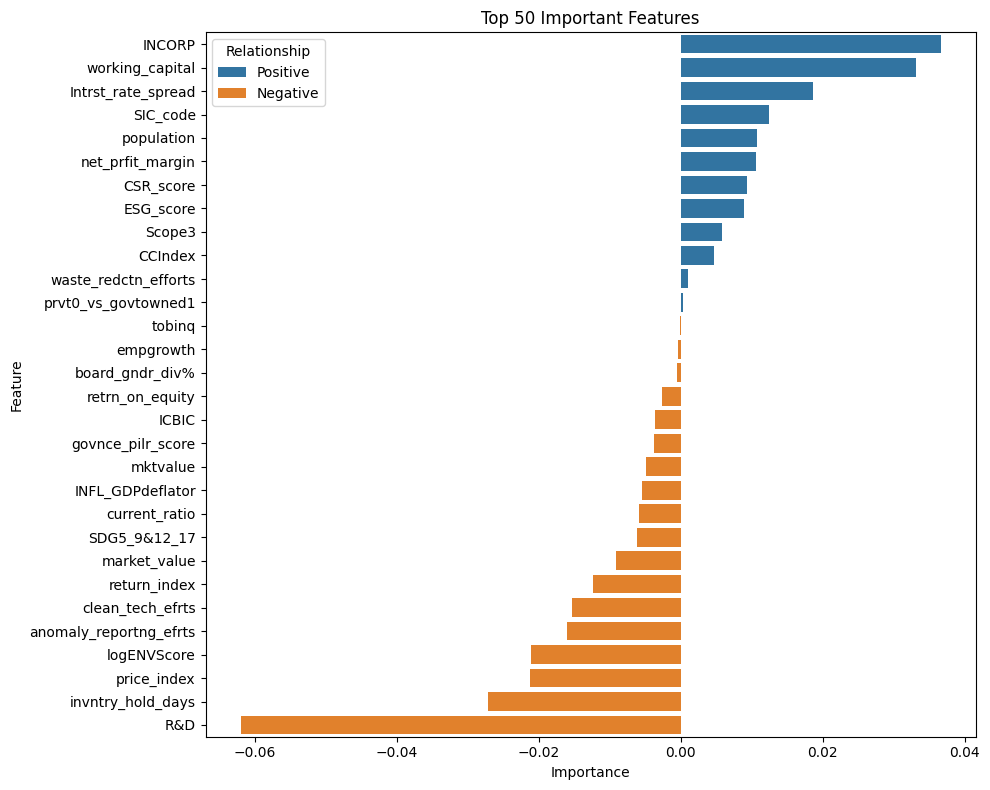

,R2 Score,Mean Squared Error,Mean Absolute Error,Explained Variance Score,Best Params
Ridge,0.083745,0.146969,0.231052,0.08375,{'alpha': 9.60714306409916}
Lasso,-0.000002,0.160402,0.247483,0.0,{'alpha': 3.845401188473625}
ElasticNet,-0.000002,0.160402,0.247483,0.0,"{'alpha': 3.845401188473625, 'l1_ratio': 0.955..."


Model evaluation metrics saved to Google Drive.
Top 50 feature importance plot saved to Google Drive.
Tabular comparison of actual and predicted values saved to Google Drive.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import uniform, randint

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Calculate Variance Inflation Factor (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X)
vif_data.to_csv('/content/drive/My Drive/vif_data_LR.csv', index=False)

# Remove features with infinite VIF values or very high VIF values
high_vif_features = vif_data[vif_data['VIF'] > 20]['feature']
X = X.drop(columns=high_vif_features)

# Recalculate VIF after removal
vif_data = calculate_vif(X)

# Reduce multicollinearity with PCA
pca = PCA(n_components=30)  # Smaller number of components
X_pca = pca.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Define models with reduced hyperparameter grids
models = {
    'Ridge': RandomizedSearchCV(Ridge(), param_distributions={'alpha': uniform(0.1, 10.0)}, n_iter=10, cv=3, random_state=42),
    'Lasso': RandomizedSearchCV(Lasso(), param_distributions={'alpha': uniform(0.1, 10.0)}, n_iter=10, cv=3, random_state=42),
    'ElasticNet': RandomizedSearchCV(ElasticNet(), param_distributions={'alpha': uniform(0.1, 10.0), 'l1_ratio': uniform(0.1, 0.9)}, n_iter=10, cv=3, random_state=42)
}

# Function to evaluate models
def evaluate_model(y_test, y_pred):
    return {
        'R2 Score': r2_score(y_test, y_pred),
        'Mean Squared Error': mean_squared_error(y_test, y_pred),
        'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
        'Explained Variance Score': explained_variance_score(y_test, y_pred)
    }

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = evaluate_model(y_test, y_pred)
    results[name]['Best Params'] = model.best_params_

# Display evaluation metrics
metrics_df = pd.DataFrame(results).T

# Ensure the 'R2 Score' column is numeric
metrics_df['R2 Score'] = pd.to_numeric(metrics_df['R2 Score'], errors='coerce')

# Get the best model name based on R2 Score
best_model_name = metrics_df['R2 Score'].idxmax()
best_model = models[best_model_name].best_estimator_

# Plot top 50 variables contributing to the prediction for the best model (based on R2 score)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
else:
    feature_importance = best_model.coef_

# Only plot if the model has a coefficient or feature_importances_ attribute
if feature_importance is not None:
    top_50_idx = np.argsort(feature_importance)[-50:][::-1]
    top_50_features = [(X.columns[i], feature_importance[i]) for i in top_50_idx]

    top_50_df = pd.DataFrame(top_50_features, columns=['Feature', 'Importance'])
    top_50_df['Relationship'] = np.where(top_50_df['Importance'] >= 0, 'Positive', 'Negative')
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_50_df, hue='Relationship', dodge=False)
    plt.title('Top 50 Important Features')
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/top_50_features.png')
    plt.show()

# Create a tabular comparison of actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': best_model.predict(X_test)})
comparison_df.to_csv('/content/drive/My Drive/actual_vs_predicted.csv', index=False)

# Print model evaluation metrics as a table
from google.colab.data_table import DataTable
display(DataTable(metrics_df))

# Display the results
print('Model evaluation metrics saved to Google Drive.')
print('Top 50 feature importance plot saved to Google Drive.')
print('Tabular comparison of actual and predicted values saved to Google Drive.')


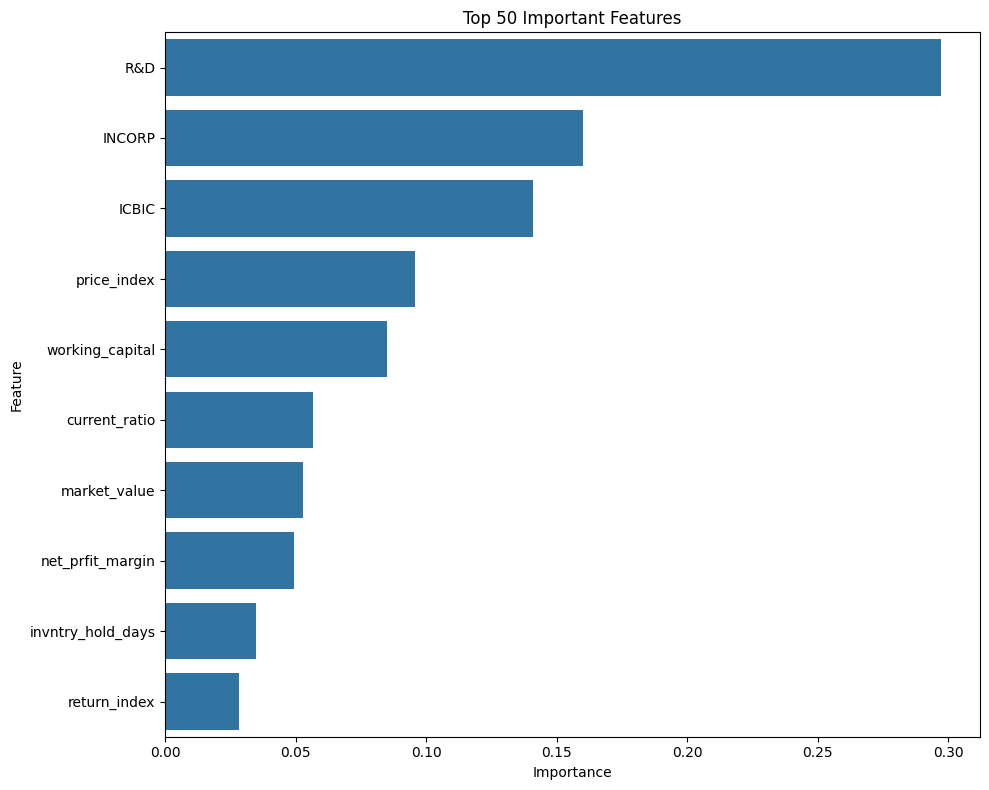

Model evaluation metrics saved to Google Drive.
Top 50 feature importance plot saved to Google Drive.
Tabular comparison of actual and predicted values saved to Google Drive.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import uniform, randint

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Calculate Variance Inflation Factor (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X)
vif_data.to_csv('/content/drive/My Drive/vif_data.csv', index=False)

# Remove features with infinite VIF values or very high VIF values
high_vif_features = vif_data[vif_data['VIF'] > 10]['feature']
X = X.drop(columns=high_vif_features)

# Recalculate VIF after removal
vif_data = calculate_vif(X)

# Reduce multicollinearity with PCA
pca = PCA(n_components=20)  # Smaller number of components
X_pca = pca.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Define models with reduced hyperparameter grids
models = {
    'Ridge': RandomizedSearchCV(Ridge(), param_distributions={'alpha': uniform(0.1, 10.0)}, n_iter=10, cv=3, random_state=42),
    'Lasso': RandomizedSearchCV(Lasso(), param_distributions={'alpha': uniform(0.1, 10.0)}, n_iter=10, cv=3, random_state=42),
    'ElasticNet': RandomizedSearchCV(ElasticNet(), param_distributions={'alpha': uniform(0.1, 10.0), 'l1_ratio': uniform(0.1, 0.9)}, n_iter=10, cv=3, random_state=42),
    'GradientBoosting': RandomizedSearchCV(GradientBoostingRegressor(), param_distributions={'n_estimators': randint(100, 150), 'learning_rate': uniform(0.01, 0.1), 'max_depth': randint(3, 5)}, n_iter=10, cv=3, random_state=42)
}

# Function to evaluate models
def evaluate_model(y_test, y_pred):
    return {
        'R2 Score': r2_score(y_test, y_pred),
        'Mean Squared Error': mean_squared_error(y_test, y_pred),
        'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
        'Explained Variance Score': explained_variance_score(y_test, y_pred)
    }

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = evaluate_model(y_test, y_pred)
    results[name]['Best Params'] = model.best_params_

# Display evaluation metrics
metrics_df = pd.DataFrame(results).T

# Ensure the 'R2 Score' column is numeric
metrics_df['R2 Score'] = pd.to_numeric(metrics_df['R2 Score'], errors='coerce')

# Get the best model name based on R2 Score
best_model_name = metrics_df['R2 Score'].idxmax()
best_model = models[best_model_name].best_estimator_

# Plot top 50 variables contributing to the prediction for the best model (based on R2 score)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
else:
    feature_importance = np.abs(best_model.coef_)

# Only plot if the model has a coefficient or feature_importances_ attribute
if feature_importance is not None:
    top_50_idx = np.argsort(feature_importance)[-50:][::-1]
    top_50_features = [(X.columns[i], feature_importance[i]) for i in top_50_idx]

    top_50_df = pd.DataFrame(top_50_features, columns=['Feature', 'Importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_50_df)
    plt.title('Top 50 Important Features')
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/top_50_features.png')
    plt.show()

# Create a tabular comparison of actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': best_model.predict(X_test)})
comparison_df.to_csv('/content/drive/My Drive/actual_vs_predicted.csv', index=False)

print(f'Model evaluation metrics saved to Google Drive.')
print(f'Top 50 feature importance plot saved to Google Drive.')
print(f'Tabular comparison of actual and predicted values saved to Google Drive.')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from google.colab import drive
import seaborn as sns

# Calculate Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
display(vif_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Ridge, Lasso, and ElasticNet models
ridge = Ridge().fit(X_train, y_train)
lasso = Lasso().fit(X_train, y_train)
elasticnet = ElasticNet().fit(X_train, y_train)

# Predict on test data
ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)
elasticnet_pred = elasticnet.predict(X_test)

# Evaluate models
def evaluate_model(y_test, y_pred):
    return {
        'R2 Score': r2_score(y_test, y_pred),
        'Mean Squared Error': mean_squared_error(y_test, y_pred),
        'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
        'Explained Variance Score': explained_variance_score(y_test, y_pred)
    }

ridge_metrics = evaluate_model(y_test, ridge_pred)
lasso_metrics = evaluate_model(y_test, lasso_pred)
elasticnet_metrics = evaluate_model(y_test, elasticnet_pred)

metrics_df = pd.DataFrame([ridge_metrics, lasso_metrics, elasticnet_metrics], index=['Ridge', 'Lasso', 'ElasticNet'])
display(metrics_df)
metrics_df.to_csv('/content/drive/My Drive/evaluation_metrics.csv', index=False)

# Train a Gradient Boosting model
boosting_model = GradientBoostingRegressor().fit(X_train, y_train)
boosting_pred = boosting_model.predict(X_test)
boosting_metrics = evaluate_model(y_test, boosting_pred)

# Plot top 50 variables contributing to the prediction for the best model (based on R2 score)
best_model = boosting_model if boosting_metrics['R2 Score'] > metrics_df['R2 Score'].max() else ridge if ridge_metrics['R2 Score'] > lasso_metrics['R2 Score'] and ridge_metrics['R2 Score'] > elasticnet_metrics['R2 Score'] else lasso if lasso_metrics['R2 Score'] > elasticnet_metrics['R2 Score'] else elasticnet

feature_importance = np.abs(best_model.coef_ if hasattr(best_model, 'coef_') else best_model.feature_importances_)
top_50_idx = np.argsort(feature_importance)[-50:][::-1]
top_50_features = [(X.columns[i], feature_importance[i]) for i in top_50_idx]

top_50_df = pd.DataFrame(top_50_features, columns=['Feature', 'Importance'])
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_50_df)
plt.title('Top 50 Important Features')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/top_50_features.png')
plt.show()

# Create a tabular comparison of actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': best_model.predict(X_test)})
display(comparison_df.head())
comparison_df.to_csv('/content/drive/My Drive/actual_vs_predicted.csv', index=False)

print(f'Model evaluation metrics saved to Google Drive.')
print(f'Top 50 feature importance plot saved to Google Drive.')
print(f'Tabular comparison of actual and predicted values saved to Google Drive.')
